# **군집화 후속분석_고객 세분화**

# 1.환경준비

## (1) 라이브러리 로딩

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score

## (2) Data Loading

In [ ]:
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/customer_segmentation.csv'
data = pd.read_csv(path)
data.head()

,CustID,Gender,Age,Income,Score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


# 2.데이터 전처리

## (1) 데이터 분할

In [ ]:
# 군집화는 아래 변수들만 사용합니다.
x = data.loc[:, ['Age', 'Income', 'Score']]

## (2) 스케일링

In [ ]:
scaler = MinMaxScaler()
x_s = scaler.fit_transform(x)

# 3.클러스터링

## (1)  k-means 모델 만들기
* k값을 늘려가면서(2~20) 모델을 만들고, inertia 값 혹은 실루엣 점수를 저장합니다.
* 그래프를 통해서 최적의 k값을 결정합니다.
    * 단, k값은 3~6개 사이에서 결정하세요.
* 선정된 k값으로 모델을 생성합니다.

In [ ]:
# k의 갯수에 따라 각 점과의 거리를 계산하여 적정한 k를 찾아 봅시다.
kvalues = range(2,20)
inertias = []
sil_score = []

for k in kvalues:
    model = KMeans(n_clusters=k, n_init = 'auto', random_state = 10)
    pred = model.fit_predict(x_s)

    inertias.append(model.inertia_)                # 이너시아
    sil_score.append(silhouette_score(x_s, pred))  # 실루엣

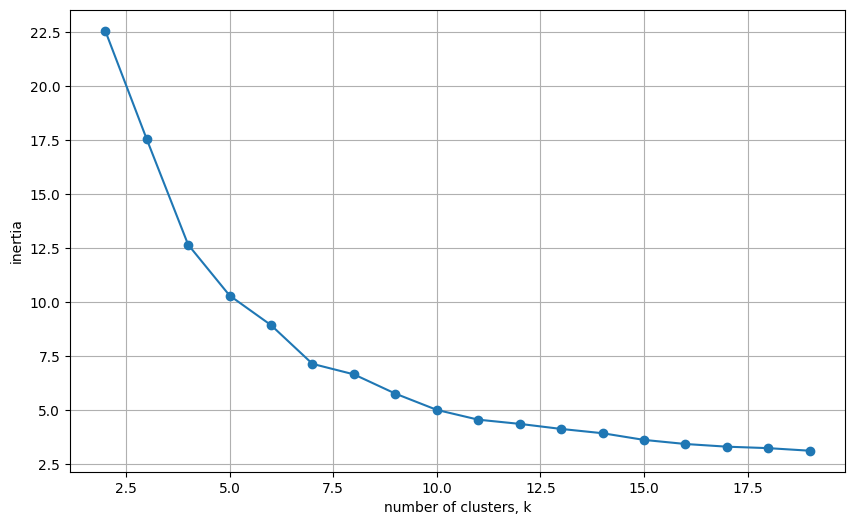

In [ ]:
# inertias plot
plt.figure(figsize = (10,6))
plt.plot(kvalues, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.grid()
plt.show()

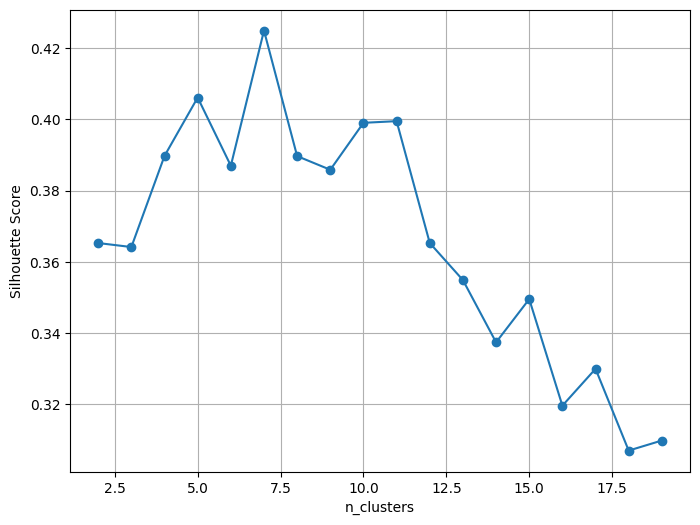

In [ ]:
# 실루엣 점수 시각화
plt.figure(figsize = (8, 6))
plt.plot(kvalues, sil_score, marker='o')
plt.xlabel('n_clusters')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show()

* 실루엣 점수 기준으로는 5 혹은 7이 가장 높습니다.
* 여기서는 군집이 너무 많아지는 것을 막기 위해서 5로 지정해 보겠습니다.

In [ ]:
model = KMeans(n_clusters=5, n_init = 'auto', random_state = 10)
model.fit(x_s)

KMeans(n_clusters=5, random_state=10)

## (2) 데이터 군집 결과 정리
* 데이터를 군집화 하여 기존 데이터와 합치기
    * pd.concat([data, pred], axis = 1)

In [ ]:
# 예측
pred = model.predict(x_s)

# 예측 결과를 데이터프레임으로 만들고
pred = pd.DataFrame(pred, columns = ['pred'])

# 원본 데이터와 합치기
result = pd.concat([data, pred], axis = 1)

# 예측 결과는 카테고리 타입으로 변경
result['pred'] = pd.Categorical(result['pred'] )
result.head()

,CustID,Gender,Age,Income,Score,pred
0,1,Male,19,15,39,4
1,2,Male,21,15,81,2
2,3,Female,20,16,6,4
3,4,Female,23,16,77,2
4,5,Female,31,17,40,4


# 4.후속 분석
* 군집별 특징을 분석해 봅시다.

In [ ]:
result

,CustID,Gender,Age,Income,Score,pred
0,1,Male,19,15,39,4
1,2,Male,21,15,81,2
2,3,Female,20,16,6,4
3,4,Female,23,16,77,2
4,5,Female,31,17,40,4
...,...,...,...,...,...,...
195,196,Female,35,120,79,3
196,197,Female,45,126,28,0
197,198,Male,32,126,74,3
198,199,Male,32,137,18,0


## (1) 군집별 변수 비교
* 활용 가능한 차트 : sns.barplot, sns.kdeplot, sns.boxplot, mosaic

In [ ]:
# 수치형 변수와 군집간 관계를 분석하는 차트 함수
def var_analysis(var, data = result):

    plt.figure(figsize = (14,4))

    plt.subplot(1,3,1)
    sns.barplot(x = 'pred', y = var, data = data)
    plt.grid()

    plt.subplot(1,3,2)
    sns.kdeplot(x = var, data = data, hue = 'pred', common_norm = False)
    plt.grid()

    plt.subplot(1,3,3)
    sns.boxplot(x = var, y = 'pred', data = data)
    plt.grid()

    plt.tight_layout()
    plt.show()

### 1) Age

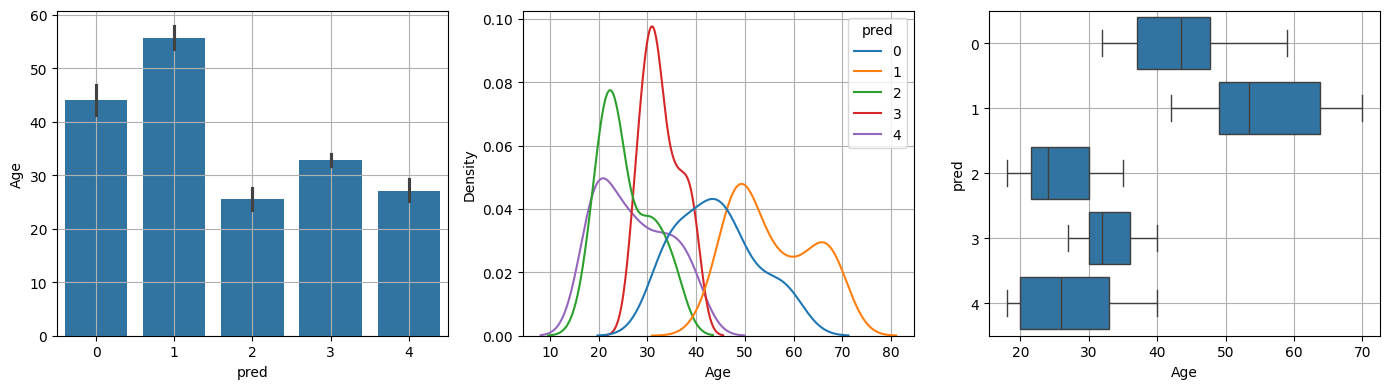

In [ ]:
var = 'Age'
var_analysis(var)

### 2) Income

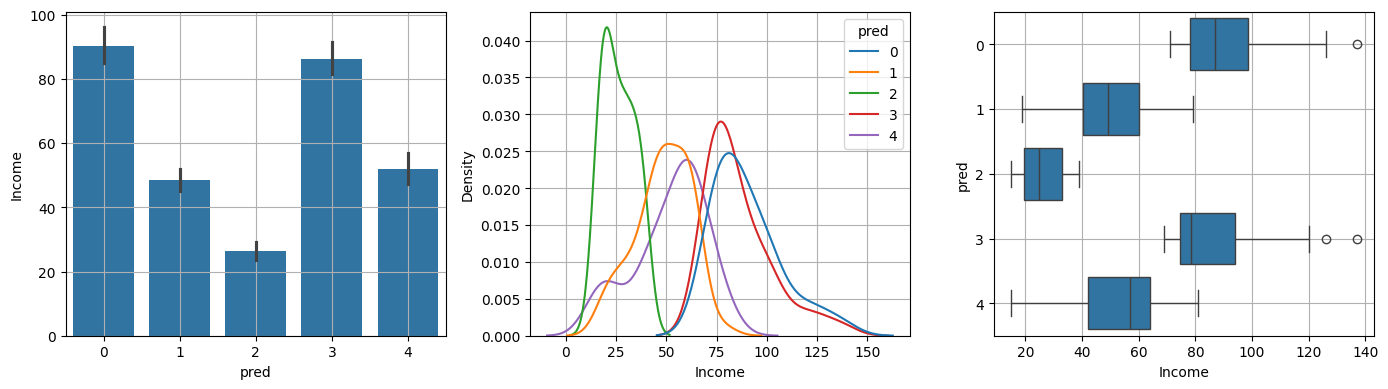

In [ ]:
var = 'Income'
var_analysis(var)

### 3) Score

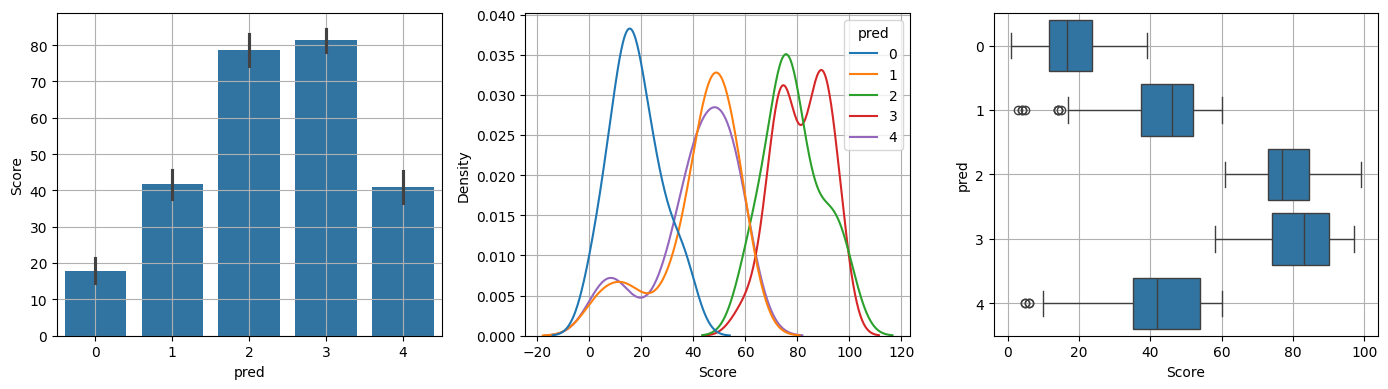

In [ ]:
var = 'Score'
var_analysis(var)

### 4) Gender
* 모자익 플롯을 사용해 봅시다.

In [ ]:
from statsmodels.graphics.mosaicplot import mosaic

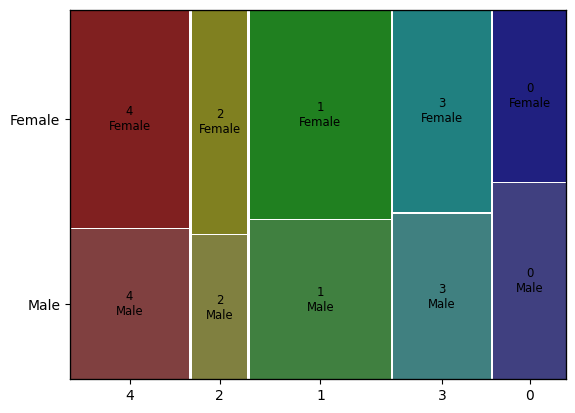

In [ ]:
mosaic(result, ['pred','Gender'])
plt.show()

## (2) 한꺼번에 비교하기
* sns.pairplot을 이용하여 한꺼번에 비교해 봅시다.

In [ ]:
cols = ['Age', 'Income', 'Score', 'pred']
temp = result.loc[:, cols]

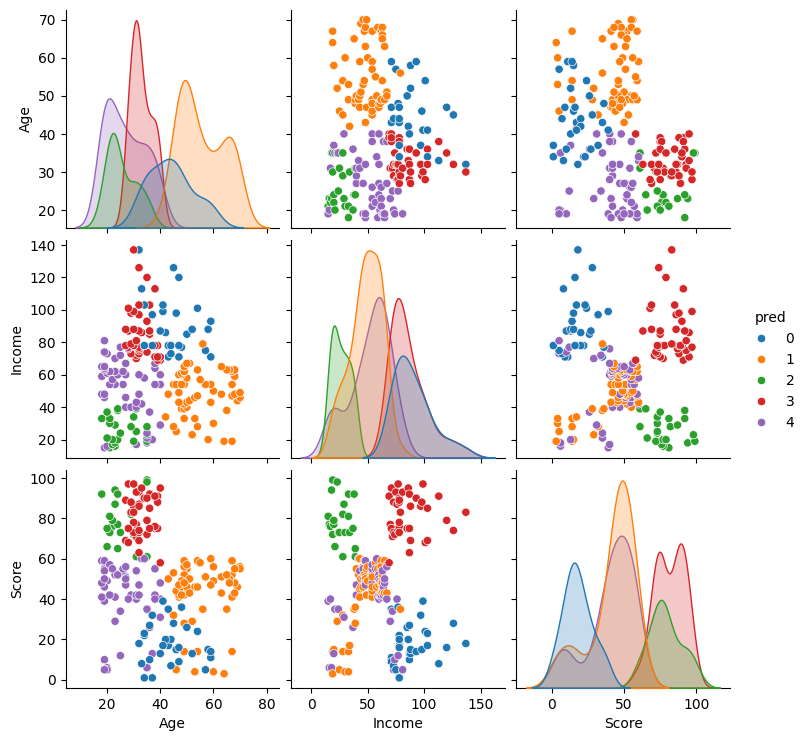

In [ ]:
sns.pairplot(temp, hue = 'pred')
plt.show()

## (3) 각 군집별 특징을 정리해 봅시다.
* 각 군집의 특징(다른 군집과 차별화 되는 요소)을 정리합시다.
* 각 군집의 특징으로 볼 때, 어떤 고객군이라고 볼 수 있을까요?
* 각 고객군에 대한 적절한 마케팅 방법은?
* 더 필요한 정보는?

## 군집별 특징 요약

*   **군집 0 (고소득 저관심층)**
    *   **특징**: 평균 나이 44세, 가장 높은 소득(약 90), 가장 낮은 쇼핑 점수(약 18). 남성 비율이 약간 높음.
    *   **마케팅 전략**: 쇼핑 참여도를 높이기 위한 가성비 제품 프로모션 및 재방문 할인.

*   **군집 1 (고연령 실용층)**
    *   **특징**: 평균 나이 55.5세로 가장 높음, 중간 소득(약 48), 중간 쇼핑 점수(약 42). 여성 비율이 약간 높음.
    *   **마케팅 전략**: 연령대에 맞는 건강, 여가 관련 실용 제품 추천 및 로열티 프로그램 운영.

*   **군집 2 (젊은 쇼핑 열정층)**
    *   **특징**: 평균 나이 25.5세로 가장 어림, 가장 낮은 소득(약 26), 가장 높은 쇼핑 점수(약 78.5). 여성 비율이 크게 높음.
    *   **마케팅 전략**: 트렌디한 저가 기획 상품, SNS 이벤트 등 젊은 층 감성과 가격 부담을 줄이는 프로모션.

*   **군집 3 (핵심 VIP층)**
    *   **특징**: 평균 나이 32.8세, 높은 소득(약 86), 높은 쇼핑 점수(약 81.5). 여성 비율이 약간 높음.
    *   **마케팅 전략**: 프리미엄 제품, VIP 혜택, 맞춤형 추천을 통한 충성도 강화.

*   **군집 4 (젊은 잠재층)**
    *   **특징**: 평균 나이 27세, 중간 소득(약 52), 중간 쇼핑 점수(약 41). 여성 비율이 크게 높음.
    *   **마케팅 전략**: 다양한 신상품 소개, 체험 기회 제공, 굿즈 증정 등으로 흥미 유발 및 구매 독려.

/tmp/ipython-input-1842500912.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_mean = result.groupby('pred')[['Age', 'Income', 'Score']].mean()


,Age,Income,Score
pred,,,
0,44.000000,90.133333,17.933333
1,55.551724,48.482759,41.775862
2,25.521739,26.304348,78.565217
3,32.875000,86.100000,81.525000
4,27.061224,51.979592,41.040816


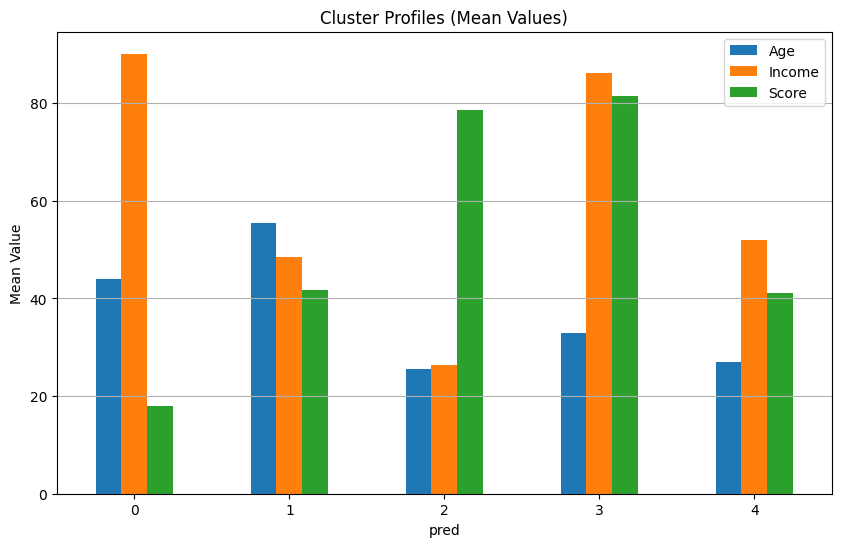

In [ ]:
# 각 군집(pred)별 Age, Income, Score의 평균을 계산
cluster_mean = result.groupby('pred')[['Age', 'Income', 'Score']].mean()
display(cluster_mean)

# 시각화 (Bar Plot)
cluster_mean.plot(kind='bar', figsize=(10, 6))
plt.title("Cluster Profiles (Mean Values)")
plt.ylabel("Mean Value")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

- 군집 0: 소득은 높으나 쇼핑 점수는 낮음->가성비 제품 프로모션, 재방문 유도 할인 쿠폰

- 군집 2: 소득은 낮으나 쇼핑 점수는 높음 ->트렌디한 저가 기획 상품 추천, SNS 이벤트